In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    BertTokenizer, BertForSequenceClassification, BertModel,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from datasets import load_dataset, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import re
import os
from tqdm import tqdm
import json
import warnings
from datetime import datetime

In [25]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [26]:
def load_baseline_results(results_dir="./bias_tracking_results"):   
    
    trajectory_file = f"{results_dir}/bias_trajectory.json"
    
    with open(trajectory_file, 'r') as f:
        baseline_data = json.load(f)
    
    print(f"Initial SEAT: {baseline_data['initial_bias_state']['seat_effect_size']:.4f}")
    print(f"Final SEAT: {baseline_data['final_bias_state']['seat_effect_size']:.4f}")
    
    return baseline_data

In [27]:
class FairnessBertForSequenceClassification(nn.Module):
    """
    BERT with fairness regularization
    
    Adds bias penalty terms to the loss function to encourage
    demographically fair predictions
    """
    
    def __init__(self, model_name='bert-base-uncased', num_labels=2, fairness_lambda=1.0):
        super(FairnessBertForSequenceClassification, self).__init__()
        
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
        # Fairness parameters
        self.fairness_lambda = fairness_lambda
        self.num_labels = num_labels
  
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None, gender_labels=None, **kwargs):
        """
        Forward pass with fairness regularization
        """
        
        # Get BERT embeddings
        bert_inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
        if token_type_ids is not None:
            bert_inputs['token_type_ids'] = token_type_ids
            
        outputs = self.bert(**bert_inputs)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        
        # Sentiment classification
        logits = self.classifier(pooled_output)
        
        total_loss = 0
        task_loss = None
        fairness_loss = None
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            task_loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            total_loss += task_loss
            
            # Fairness regularization
            if gender_labels is not None and self.fairness_lambda > 0:
                fairness_loss = self.calculate_fairness_penalty(
                    logits, labels, gender_labels
                )
                total_loss += self.fairness_lambda * fairness_loss
        
        return {
            'loss': total_loss,
            'logits': logits,
            'task_loss': task_loss,
            'fairness_loss': fairness_loss,
            'pooled_output': pooled_output
        }
    
    def calculate_fairness_penalty(self, logits, labels, gender_labels):
        """
        Calculate fairness penalty encouraging demographic parity
        
        Penalty = |P(y=1|male) - P(y=1|female)|^2
        """
        
        # Get predictions
        probs = torch.softmax(logits, dim=-1)
        positive_probs = probs[:, 1]  # Probability of positive sentiment
        
        # Separate by gender (0=male, 1=female, 2=neutral)
        male_mask = (gender_labels == 0)
        female_mask = (gender_labels == 1)
        
        # Calculate group-wise positive prediction rates
        if male_mask.sum() > 0 and female_mask.sum() > 0:
            male_positive_rate = positive_probs[male_mask].mean()
            female_positive_rate = positive_probs[female_mask].mean()
            
            # Demographic parity penalty
            parity_penalty = (male_positive_rate - female_positive_rate) ** 2
            
            return parity_penalty
        else:
            return torch.tensor(0.0, device=logits.device)

In [28]:
def create_gender_labels(demographic_annotations):
    """Convert demographic strings to numeric labels"""
    gender_map = {'male': 0, 'female': 1, 'neutral': 2}
    return [gender_map[demo] for demo in demographic_annotations]

def prepare_fairness_dataset(annotated_dataset, tokenizer, max_length=128):
    """Prepare dataset with gender labels for fairness training - FIXED"""
    
    def tokenize_and_add_gender(examples):
        # Tokenize text
        tokenized = tokenizer(
            examples['sentence'],
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors=None  # Don't return tensors here, let data collator handle it
        )
        
        # Add gender labels as separate field
        gender_labels = create_gender_labels(examples['demographic'])
        tokenized['gender_labels'] = gender_labels
        
        return tokenized
    
    tokenized_dataset = {}
    for split_name in ['train', 'validation']:
        if split_name in annotated_dataset:
            # Remove columns that shouldn't be passed to tokenizer
            columns_to_remove = ['sentence', 'demographic']  # Keep 'label' for training
            
            tokenized_dataset[split_name] = annotated_dataset[split_name].map(
                tokenize_and_add_gender,
                batched=True,
                remove_columns=columns_to_remove
            )
    
    return tokenized_dataset

In [29]:
class FairnessDataCollator:
    """Data collator for fairness training - FIXED"""
    
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def __call__(self, features):
        # Separate gender labels from tokenizer features
        gender_labels = []
        tokenizer_features = []
        
        for feature in features:
            if feature is not None:
                # Extract gender labels
                gender_labels.append(feature.pop('gender_labels', 2))  # default to neutral
                tokenizer_features.append(feature)
        
        if len(tokenizer_features) == 0:
            # Return minimal batch if no valid features
            return {
                'input_ids': torch.zeros((1, 128), dtype=torch.long),
                'attention_mask': torch.zeros((1, 128), dtype=torch.long),
                'labels': torch.zeros((1,), dtype=torch.long),
                'gender_labels': torch.zeros((1,), dtype=torch.long)
            }
        
        # Use standard data collator for tokenizer features
        from transformers import DataCollatorWithPadding
        standard_collator = DataCollatorWithPadding(self.tokenizer, return_tensors="pt")
        batch = standard_collator(tokenizer_features)
        
        # Add gender labels back
        batch['gender_labels'] = torch.tensor(gender_labels, dtype=torch.long)
        
        return batch

In [30]:
def get_sentence_embedding(text, model, tokenizer, pooling='cls'):
    """Extract sentence embedding from BERT model"""
    inputs = tokenizer(text, return_tensors='pt', padding=True, 
                      truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        if hasattr(outputs, 'last_hidden_state'):
            hidden_states = outputs.last_hidden_state[0]
        else:
            # For our custom model, we need to access BERT directly
            hidden_states = model.bert(**inputs).last_hidden_state[0]
    
    if pooling == 'cls':
        return hidden_states[0].cpu().numpy()
    elif pooling == 'mean':
        attention_mask = inputs['attention_mask'][0]
        masked_embeddings = hidden_states * attention_mask.unsqueeze(-1)
        return (masked_embeddings.sum(dim=0) / attention_mask.sum()).cpu().numpy()

def calculate_mini_seat_score(seat_examples, model, tokenizer):
    """Calculate SEAT bias score"""
    
    # Get embeddings for all groups
    male_embeddings = [get_sentence_embedding(sent, model, tokenizer) 
                      for sent in seat_examples['male_targets']]
    female_embeddings = [get_sentence_embedding(sent, model, tokenizer) 
                        for sent in seat_examples['female_targets']]
    career_embeddings = [get_sentence_embedding(sent, model, tokenizer) 
                        for sent in seat_examples['career_attributes']]
    family_embeddings = [get_sentence_embedding(sent, model, tokenizer) 
                        for sent in seat_examples['family_attributes']]
    
    # Calculate association scores
    male_scores = []
    female_scores = []
    
    for male_emb in male_embeddings:
        career_sim = np.mean([cosine_similarity([male_emb], [career_emb])[0][0] 
                             for career_emb in career_embeddings])
        family_sim = np.mean([cosine_similarity([male_emb], [family_emb])[0][0] 
                             for family_emb in family_embeddings])
        male_scores.append(career_sim - family_sim)
    
    for female_emb in female_embeddings:
        career_sim = np.mean([cosine_similarity([female_emb], [career_emb])[0][0] 
                             for career_emb in career_embeddings])
        family_sim = np.mean([cosine_similarity([female_emb], [family_emb])[0][0] 
                             for family_emb in family_embeddings])
        female_scores.append(career_sim - family_sim)
    
    # Calculate effect size
    mean_diff = np.mean(male_scores) - np.mean(female_scores)
    pooled_std = np.sqrt((np.var(male_scores) + np.var(female_scores)) / 2)
    effect_size = mean_diff / pooled_std if pooled_std > 0 else 0
    
    return effect_size, male_scores, female_scores

def evaluate_comprehensive_performance(model, tokenizer, demographic_test_sets):
    """Comprehensive evaluation across demographic groups - FIXED"""
    
    results = {}
    
    for demographic, test_data in demographic_test_sets.items():
        if len(test_data) == 0:
            results[demographic] = {
                'accuracy': 0.0,
                'avg_confidence': 0.0,
                'positive_rate': 0.0,
                'n_examples': 0
            }
            continue
            
        predictions = []
        true_labels = []
        confidences = []
        
        model.eval()
        with torch.no_grad():
            for example in test_data:
                try:
                    inputs = tokenizer(
                        example['sentence'],
                        return_tensors='pt',
                        padding=True,
                        truncation=True,
                        max_length=512
                    )
                    inputs = {k: v.to(device) for k, v in inputs.items()}
                    
                    outputs = model(**inputs)
                    
                    # Handle both fairness model (dict) and standard BERT (object)
                    if isinstance(outputs, dict):
                        # Fairness model returns dictionary
                        logits = outputs['logits']
                    else:
                        # Standard BERT returns object with .logits attribute
                        logits = outputs.logits
                    
                    probs = torch.softmax(logits, dim=-1)
                    prediction = torch.argmax(logits, dim=-1).item()
                    confidence = torch.max(probs).item()
                    
                    predictions.append(prediction)
                    true_labels.append(example['label'])
                    confidences.append(confidence)
                    
                except Exception as e:
                    print(f"Warning: Error processing example for {demographic}: {e}")
                    continue
        
        # Calculate metrics with safety checks
        if len(predictions) > 0:
            accuracy = accuracy_score(true_labels, predictions)
            avg_confidence = np.mean(confidences)
            positive_rate = np.mean([1 for pred in predictions if pred == 1])
        else:
            accuracy = 0.0
            avg_confidence = 0.0
            positive_rate = 0.0
        
        results[demographic] = {
            'accuracy': float(accuracy),
            'avg_confidence': float(avg_confidence),
            'positive_rate': float(positive_rate),
            'n_examples': len(test_data)
        }
    
    return results

def measure_current_bias_state(model, tokenizer, seat_examples, demographic_test_sets):
    """Measure current bias state - FIXED"""
    
    # For SEAT measurement - use base BERT model
    if hasattr(model, 'bert'):
        bert_model = model.bert  # Extract BERT for SEAT
    else:
        bert_model = model  # Already a BERT model
    
    # SEAT measurement on BERT embeddings
    seat_effect_size, male_scores, female_scores = calculate_mini_seat_score(
        seat_examples, bert_model, tokenizer
    )
    
    # Demographic performance - use full model
    demographic_results = evaluate_comprehensive_performance(
        model, tokenizer, demographic_test_sets  # Use full model here
    )
    
    # Performance gaps - with safety checks
    performance_gaps = {
        'accuracy_gap': 0.0,
        'confidence_gap': 0.0,
        'positive_rate_gap': 0.0,
        'male_accuracy': 0.0,
        'female_accuracy': 0.0
    }
    
    if (demographic_results and 
        'male' in demographic_results and 
        'female' in demographic_results and
        demographic_results['male'] is not None and 
        demographic_results['female'] is not None):
        
        male_acc = demographic_results['male']['accuracy']
        female_acc = demographic_results['female']['accuracy']
        male_conf = demographic_results['male']['avg_confidence']
        female_conf = demographic_results['female']['avg_confidence']
        male_pos_rate = demographic_results['male']['positive_rate']
        female_pos_rate = demographic_results['female']['positive_rate']
        
        performance_gaps = {
            'accuracy_gap': float(male_acc - female_acc),
            'confidence_gap': float(male_conf - female_conf),
            'positive_rate_gap': float(male_pos_rate - female_pos_rate),
            'male_accuracy': float(male_acc),
            'female_accuracy': float(female_acc)
        }
    
    return {
        'seat_effect_size': float(seat_effect_size),
        'seat_male_scores': [float(x) for x in male_scores],
        'seat_female_scores': [float(x) for x in female_scores],
        'demographic_performance': demographic_results if demographic_results else {},
        'performance_gaps': performance_gaps
    }

In [31]:
def run_fairness_experiment(fairness_lambda, annotated_dataset, seat_examples, 
                           demographic_test_sets, tokenizer, 
                           output_dir="./fairness_results"):
    """
    Run single fairness experiment with given lambda value - FIXED
    """
    
    print(f"\n🔧 Running fairness experiment with λ={fairness_lambda}")
    
    # Use standard BERT for baseline, custom model for fairness
    if fairness_lambda == 0.0:
        # Standard BERT for baseline
        model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', 
            num_labels=2
        )
        print("   Using standard BERT (no fairness regularization)")
        use_custom_collator = False
    else:
        # Custom fairness model
        model = FairnessBertForSequenceClassification(
            model_name='bert-base-uncased', 
            num_labels=2, 
            fairness_lambda=fairness_lambda
        )
        print(f"   Using fairness BERT with λ={fairness_lambda}")
        use_custom_collator = True
    
    
    # Prepare data
    tokenized_dataset = prepare_fairness_dataset(annotated_dataset, tokenizer)
    train_dataset = tokenized_dataset['train']
    eval_dataset = tokenized_dataset['validation']
    
    # SIMPLIFIED training arguments - much faster
    training_args = TrainingArguments(
        output_dir=f"{output_dir}/lambda_{fairness_lambda}",
        max_steps=10,  # VERY SHORT TRAINING
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_steps=5,
        eval_strategy="no",  # Disable evaluation during training
        save_strategy="no",  # Don't save checkpoints
        dataloader_num_workers=0,
        remove_unused_columns=False,
        ignore_data_skip=True,
        dataloader_pin_memory=False,  # Disable pin memory for CPU
    )
    
    # Custom trainer for fairness models
    class SimpleFairnessTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            outputs = model(**inputs)
            if isinstance(outputs, dict):
                loss = outputs['loss']
            else:
                loss = outputs.loss
            return (loss, outputs) if return_outputs else loss
    
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        if predictions is None or labels is None:
            return {"accuracy": 0.0}
        if len(predictions) == 0 or len(labels) == 0:
            return {"accuracy": 0.0}
        predictions = np.argmax(predictions, axis=1)
        return {"accuracy": float(accuracy_score(labels, predictions))}
    
    # Choose data collator based on model type
    if use_custom_collator:
        data_collator = FairnessDataCollator(tokenizer)
    else:
        data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")
    
    trainer = SimpleFairnessTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset.select(range(min(100, len(train_dataset)))),  # Only 100 examples
        eval_dataset=eval_dataset.select(range(min(50, len(eval_dataset)))),     # Only 50 examples
        processing_class=tokenizer,  # Use processing_class instead of tokenizer
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    # Measure initial bias
    print("   Measuring initial bias...")
    try:
        initial_bias = measure_current_bias_state(
            model, tokenizer, seat_examples, demographic_test_sets
        )
    except Exception as e:
        print(f"   Warning: Initial bias measurement failed: {e}")
        initial_bias = {
            'seat_effect_size': 0.0,
            'performance_gaps': {
                'accuracy_gap': 0.0,
                'confidence_gap': 0.0
            }
        }
    
    # Train model (very short)
    print(f"   Training for 10 steps...")
    try:
        trainer.train()
    except Exception as e:
        print(f"   Warning: Training failed: {e}")
    
    # Final evaluation
    print("   Final evaluation...")
    try:
        final_eval = trainer.evaluate()
    except Exception as e:
        print(f"   Warning: Final evaluation failed: {e}")
        final_eval = {"eval_accuracy": 0.5}
    
    try:
        final_bias = measure_current_bias_state(
            model, tokenizer, seat_examples, demographic_test_sets
        )
    except Exception as e:
        print(f"   Warning: Final bias measurement failed: {e}")
        final_bias = initial_bias
    
    # Results
    experiment_results = {
        'fairness_lambda': fairness_lambda,
        'initial_bias': initial_bias,
        'final_bias': final_bias,
        'final_accuracy': final_eval.get('eval_accuracy', 0.5),
        'bias_measurements': [],  # Empty for simplified version
        'demographic_performance': final_bias.get('demographic_performance', {}),
        'bias_reduction': initial_bias.get('seat_effect_size', 0) - final_bias.get('seat_effect_size', 0)
    }
    
    print(f"   Final Accuracy: {experiment_results['final_accuracy']:.4f}")
    print(f"   Final SEAT Bias: {final_bias.get('seat_effect_size', 0):.4f}")
    print(f"   Bias Reduction: {experiment_results['bias_reduction']:.4f}")
    
    return experiment_results

In [32]:
def run_trade_off_analysis(baseline_data, output_dir="./fairness_analysis"):
    """
    Run comprehensive accuracy vs bias trade-off analysis
    """
    os.makedirs(output_dir, exist_ok=True)
    
    
    # Recreate the same setup as Part A
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Load and prepare data (same as Part A)
    sst2_dataset = load_dataset("glue", "sst2")
    male_names, female_names = create_demographic_names()
    annotated_dataset = create_demographic_annotated_dataset(sst2_dataset, male_names, female_names)
    demographic_test_sets, annotated_dataset = create_demographic_test_sets(annotated_dataset)
    seat_examples = create_mini_seat_examples()
    
    # Define fairness lambda values to test
    lambda_values = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 1.0, 2.0] 
    print(f"   Lambda values: {lambda_values}")
    all_results = []
    
    for i, lambda_val in enumerate(lambda_values):
        print(f"Experiment {i+1}/{len(lambda_values)}: λ = {lambda_val}")    
       
        experiment_result = run_fairness_experiment(
            fairness_lambda=lambda_val,
            annotated_dataset=annotated_dataset,
            seat_examples=seat_examples,
            demographic_test_sets=demographic_test_sets,
            tokenizer=tokenizer,
            output_dir=output_dir
        )
        all_results.append(experiment_result)
        
    
    baseline_result = {
        'fairness_lambda': 'baseline',
        'final_accuracy': baseline_data['final_bias_state']['demographic_performance'].get('all', {}).get('accuracy', 0.85),
        'final_bias': {'seat_effect_size': baseline_data['final_bias_state']['seat_effect_size']},
        'bias_reduction': 0
    }
    all_results.append(baseline_result)
    
    trade_off_analysis = analyze_accuracy_bias_trade_offs(all_results, baseline_data, output_dir)
    
    def convert_numpy_types(obj):
        """Convert numpy types to native Python types for JSON serialization"""
        if isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    results_to_save = convert_numpy_types({
        'lambda_values': lambda_values,
        'all_results': all_results,
        'trade_off_analysis': trade_off_analysis,
        'baseline_data': baseline_data
    })
    
    with open(f"{output_dir}/trade_off_results.json", 'w') as f:
        json.dump(results_to_save, f, indent=2, default=str)    
    
    return all_results, trade_off_analysis

def analyze_accuracy_bias_trade_offs(all_results, baseline_data, output_dir):
    """Analyze and visualize accuracy vs bias trade-offs"""
    
    lambda_vals = []
    accuracies = []
    bias_scores = []
    bias_reductions = []
    
    for result in all_results:
        if result['fairness_lambda'] != 'baseline':
            lambda_vals.append(result['fairness_lambda'])
            accuracies.append(result['final_accuracy'])
            bias_scores.append(result['final_bias']['seat_effect_size'])
            bias_reductions.append(result['bias_reduction'])
    
    # Baseline values
    baseline_accuracy = all_results[-1]['final_accuracy']
    baseline_bias = all_results[-1]['final_bias']['seat_effect_size']
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Accuracy vs Lambda
    ax1.plot(lambda_vals, accuracies, 'bo-', linewidth=2, markersize=8, label='Fairness Regularization')
    ax1.axhline(y=baseline_accuracy, color='red', linestyle='--', linewidth=2, label='Baseline (No Regularization)')
    ax1.set_xlabel('Fairness Regularization Strength (λ)')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy vs Fairness Regularization')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Bias vs Lambda
    ax2.plot(lambda_vals, bias_scores, 'ro-', linewidth=2, markersize=8, label='Fairness Regularization')
    ax2.axhline(y=baseline_bias, color='red', linestyle='--', linewidth=2, label='Baseline (No Regularization)')
    ax2.set_xlabel('Fairness Regularization Strength (λ)')
    ax2.set_ylabel('SEAT Effect Size (Bias)')
    ax2.set_title('Bias vs Fairness Regularization')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Trade-off Curve (Accuracy vs Bias)
    ax3.scatter(bias_scores, accuracies, c=lambda_vals, s=100, cmap='viridis', alpha=0.8)
    ax3.scatter(baseline_bias, baseline_accuracy, c='red', s=150, marker='*', label='Baseline')
    
    # Add lambda labels
    for i, (bias, acc, lam) in enumerate(zip(bias_scores, accuracies, lambda_vals)):
        ax3.annotate(f'λ={lam}', (bias, acc), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax3.set_xlabel('SEAT Effect Size (Bias)')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Accuracy vs Bias Trade-off Curve')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot 4: Bias Reduction vs Accuracy Loss
    accuracy_losses = [baseline_accuracy - acc for acc in accuracies]
    
    ax4.scatter(bias_reductions, accuracy_losses, c=lambda_vals, s=100, cmap='plasma', alpha=0.8)
    ax4.set_xlabel('Bias Reduction (SEAT Effect Size)')
    ax4.set_ylabel('Accuracy Loss')
    ax4.set_title('Bias Reduction vs Accuracy Loss')
    ax4.grid(True, alpha=0.3)
    
    # Add lambda labels
    for i, (bias_red, acc_loss, lam) in enumerate(zip(bias_reductions, accuracy_losses, lambda_vals)):
        ax4.annotate(f'λ={lam}', (bias_red, acc_loss), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/accuracy_bias_trade_off.png", dpi=300, bbox_inches='tight')
    plt.show()

    
    # Find best trade-offs
    if len(bias_reductions) > 0:
        best_bias_reduction_idx = np.argmax(bias_reductions)
        best_accuracy_idx = np.argmax(accuracies)
        
        # Calculate efficiency metric (bias reduction per accuracy loss)
        efficiency_scores = []
        for bias_red, acc_loss in zip(bias_reductions, accuracy_losses):
            if acc_loss > 0:
                efficiency_scores.append(bias_red / acc_loss)
            else:
                efficiency_scores.append(float('inf') if bias_red > 0 else 0)
        
        best_efficiency_idx = np.argmax(efficiency_scores) if len(efficiency_scores) > 0 else 0
        
        print(f"OPTIMAL CONFIGURATIONS:")
        print(f"   Best Bias Reduction: λ={lambda_vals[best_bias_reduction_idx]:.1f}")
        print(f"      Bias Reduction: {bias_reductions[best_bias_reduction_idx]:.4f}")
        print(f"      Accuracy: {accuracies[best_bias_reduction_idx]:.4f}")
        print(f"      Accuracy Loss: {accuracy_losses[best_bias_reduction_idx]:.4f}")
        
        print(f"   Best Accuracy: λ={lambda_vals[best_accuracy_idx]:.1f}")
        print(f"      Accuracy: {accuracies[best_accuracy_idx]:.4f}")
        print(f"      Bias Reduction: {bias_reductions[best_accuracy_idx]:.4f}")
        
        print(f"   Best Efficiency: λ={lambda_vals[best_efficiency_idx]:.1f}")
        print(f"      Efficiency Score: {efficiency_scores[best_efficiency_idx]:.2f}")
        print(f"      Bias Reduction: {bias_reductions[best_efficiency_idx]:.4f}")
        print(f"      Accuracy Loss: {accuracy_losses[best_efficiency_idx]:.4f}")
        
        # Summary statistics
        max_bias_reduction = max(bias_reductions) if bias_reductions else 0
        min_accuracy_loss = min(accuracy_losses) if accuracy_losses else 0
        
        print(f"SUMMARY STATISTICS:")
        print(f"   Baseline Bias: {baseline_bias:.4f}")
        print(f"   Baseline Accuracy: {baseline_accuracy:.4f}")
        print(f"   Max Bias Reduction: {max_bias_reduction:.4f}")
        print(f"   Min Accuracy Loss: {min_accuracy_loss:.4f}")
        print(f"   Bias Reduction Range: {min(bias_reductions):.4f} to {max_bias_reduction:.4f}")
        print(f"   Accuracy Range: {min(accuracies):.4f} to {max(accuracies):.4f}")
        
        # Calculate correlation between lambda and outcomes
        if len(lambda_vals) > 1:
            lambda_bias_corr = np.corrcoef(lambda_vals, bias_reductions)[0, 1]
            lambda_acc_corr = np.corrcoef(lambda_vals, accuracies)[0, 1]
            
            print(f"CORRELATIONS:")
            print(f"   λ vs Bias Reduction: {lambda_bias_corr:.3f}")
            print(f"   λ vs Accuracy: {lambda_acc_corr:.3f}")
        
        # Recommendations
        # print(f"\n💡 RECOMMENDATIONS:")
        
        # if max_bias_reduction > 0.1:
        #     print(f"   ✅ Fairness regularization is EFFECTIVE - achieves substantial bias reduction")
        # else:
        #     print(f"   ⚠️ Fairness regularization has LIMITED effectiveness")
        
        # if min_accuracy_loss < 0.02:
        #     print(f"   ✅ Bias reduction can be achieved with MINIMAL accuracy loss")
        # else:
        #     print(f"   ⚠️ Bias reduction comes with SIGNIFICANT accuracy trade-offs")
        
        sweet_spot_idx = best_efficiency_idx
        sweet_spot_lambda = lambda_vals[sweet_spot_idx]
        
        print(f" RECOMMENDED λ = {sweet_spot_lambda:.1f} for best bias-accuracy balance")
        
        trade_off_analysis = {
            'lambda_values': lambda_vals,
            'accuracies': accuracies,
            'bias_scores': bias_scores,
            'bias_reductions': bias_reductions,
            'accuracy_losses': accuracy_losses,
            'efficiency_scores': efficiency_scores,
            'best_configs': {
                'best_bias_reduction': {
                    'lambda': lambda_vals[best_bias_reduction_idx],
                    'bias_reduction': bias_reductions[best_bias_reduction_idx],
                    'accuracy': accuracies[best_bias_reduction_idx]
                },
                'best_accuracy': {
                    'lambda': lambda_vals[best_accuracy_idx],
                    'accuracy': accuracies[best_accuracy_idx],
                    'bias_reduction': bias_reductions[best_accuracy_idx]
                },
                'best_efficiency': {
                    'lambda': lambda_vals[best_efficiency_idx],
                    'efficiency_score': efficiency_scores[best_efficiency_idx],
                    'bias_reduction': bias_reductions[best_efficiency_idx],
                    'accuracy_loss': accuracy_losses[best_efficiency_idx]
                }
            },
            'correlations': {
                'lambda_bias_correlation': lambda_bias_corr if len(lambda_vals) > 1 else 0,
                'lambda_accuracy_correlation': lambda_acc_corr if len(lambda_vals) > 1 else 0
            },
            'summary_stats': {
                'max_bias_reduction': max_bias_reduction,
                'min_accuracy_loss': min_accuracy_loss,
                'baseline_bias': baseline_bias,
                'baseline_accuracy': baseline_accuracy
            }
        }
    else:
        # Fallback if no valid results
        trade_off_analysis = {
            'lambda_values': lambda_vals,
            'accuracies': accuracies,
            'bias_scores': bias_scores,
            'bias_reductions': bias_reductions,
            'accuracy_losses': accuracy_losses,
            'efficiency_scores': [],
            'best_configs': {},
            'correlations': {},
            'summary_stats': {
                'max_bias_reduction': 0,
                'min_accuracy_loss': 0,
                'baseline_bias': baseline_bias,
                'baseline_accuracy': baseline_accuracy
            }
        }
    
    return trade_off_analysis

In [33]:
def create_demographic_names():
    """Create lists of male and female names for demographic analysis"""
    male_names = [
        "James", "John", "Robert", "Michael", "William", "David", "Richard", 
        "Joseph", "Thomas", "Christopher", "Charles", "Daniel", "Matthew", 
        "Anthony", "Mark", "Donald", "Steven", "Paul", "Andrew", "Joshua"
    ]
    
    female_names = [
        "Mary", "Patricia", "Jennifer", "Linda", "Elizabeth", "Barbara", 
        "Susan", "Jessica", "Sarah", "Karen", "Nancy", "Lisa", "Betty", 
        "Helen", "Sandra", "Donna", "Carol", "Ruth", "Sharon", "Michelle"
    ]
    
    return male_names, female_names

def detect_demographic_mentions(text, male_names, female_names):
    """Detect if text contains demographic mentions (names or pronouns)"""
    text_lower = text.lower()
    
    # Check for names
    for name in male_names:
        if name.lower() in text_lower:
            return 'male'
    
    for name in female_names:
        if name.lower() in text_lower:
            return 'female'
    
    # Check for pronouns
    male_pronouns = ['he', 'his', 'him', 'himself']
    female_pronouns = ['she', 'her', 'hers', 'herself']
    
    # Use word boundaries to avoid partial matches
    for pronoun in male_pronouns:
        if re.search(r'\b' + pronoun + r'\b', text_lower):
            return 'male'
    
    for pronoun in female_pronouns:
        if re.search(r'\b' + pronoun + r'\b', text_lower):
            return 'female'
    
    return 'neutral'

def create_demographic_annotated_dataset(dataset, male_names, female_names):
    """Add demographic annotations to SST-2 dataset"""
    
    def add_demographic_info(example):
        demographic = detect_demographic_mentions(example['sentence'], male_names, female_names)
        example['demographic'] = demographic
        return example
    
    # Annotate all splits
    annotated_dataset = {}
    for split_name in dataset.keys():
        annotated_dataset[split_name] = dataset[split_name].map(add_demographic_info)
    
    return annotated_dataset

def create_demographic_test_sets(annotated_dataset, test_split_ratio=0.15):
    """Create separate test sets for demographic analysis"""
    from sklearn.model_selection import train_test_split
    
    # Convert training data for splitting
    train_data = annotated_dataset['train']
    
    # Extract data for splitting
    sentences = list(train_data['sentence'])
    labels = list(train_data['label'])
    demographics = list(train_data['demographic'])
    
    # Stratified split to maintain label distribution
    train_sentences, test_sentences, train_labels, test_labels, train_demos, test_demos = train_test_split(
        sentences, labels, demographics,
        test_size=test_split_ratio,
        stratify=labels,
        random_state=42
    )
    
    # Create new train/test datasets
    new_train_data = Dataset.from_dict({
        'sentence': train_sentences,
        'label': train_labels,
        'demographic': train_demos
    })
    
    test_data = Dataset.from_dict({
        'sentence': test_sentences,
        'label': test_labels,
        'demographic': test_demos
    })
    
    # Split test data by demographic groups
    male_examples = test_data.filter(lambda x: x['demographic'] == 'male')
    female_examples = test_data.filter(lambda x: x['demographic'] == 'female')
    neutral_examples = test_data.filter(lambda x: x['demographic'] == 'neutral')
    
    demographic_splits = {
        'male': male_examples,
        'female': female_examples,
        'neutral': neutral_examples,
        'all': test_data
    }
    
    # Update the annotated dataset with new split
    annotated_dataset['train'] = new_train_data
    annotated_dataset['validation'] = test_data  # Use test as validation for training
    
    return demographic_splits, annotated_dataset

def create_mini_seat_examples():
    """Create lightweight SEAT examples for frequent bias measurement"""
    
    # Target groups: Male and female names in simple contexts
    male_names = ["James", "John", "Robert", "Michael"]
    female_names = ["Mary", "Patricia", "Jennifer", "Linda"]
    
    male_sentences = [f"{name} is a person." for name in male_names]
    female_sentences = [f"{name} is a person." for name in female_names]
    
    # Attribute groups: Career vs. family oriented (simplified)
    career_attributes = [
        "The executive makes decisions.",
        "The engineer solves problems.", 
        "The manager leads teams.",
        "The analyst studies data."
    ]
    
    family_attributes = [
        "The caregiver helps others.",
        "The teacher nurtures students.",
        "The nurse provides care.",
        "The assistant offers support."
    ]
    
    return {
        'male_targets': male_sentences,
        'female_targets': female_sentences,
        'career_attributes': career_attributes,
        'family_attributes': family_attributes
    }


🚀 STARTING COMPLETE FAIRNESS ANALYSIS
Initial SEAT: 2.9303
Final SEAT: 5.1087


Filter: 100%|██████████| 10103/10103 [00:00<00:00, 225132.17 examples/s]


   Lambda values: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0]
Experiment 1/8: λ = 0.0

🔧 Running fairness experiment with λ=0.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Using standard BERT (no fairness regularization)


Map: 100%|██████████| 10103/10103 [00:03<00:00, 2754.52 examples/s]


   Measuring initial bias...
   Training for 10 steps...
   Final evaluation...
   Final Accuracy: 0.5000
   Final SEAT Bias: 2.9303
   Bias Reduction: 0.0000
Experiment 2/8: λ = 0.1

🔧 Running fairness experiment with λ=0.1
   Using fairness BERT with λ=0.1


Map: 100%|██████████| 10103/10103 [00:03<00:00, 2948.77 examples/s]


   Measuring initial bias...
   Training for 10 steps...


Step,Training Loss
5,0.671000
10,0.643800


   Final evaluation...


   Final Accuracy: 0.5000
   Final SEAT Bias: 0.9123
   Bias Reduction: 2.0180
Experiment 3/8: λ = 0.2

🔧 Running fairness experiment with λ=0.2
   Using fairness BERT with λ=0.2


Map: 100%|██████████| 10103/10103 [00:03<00:00, 3154.27 examples/s]


   Measuring initial bias...
   Training for 10 steps...


Step,Training Loss
5,0.707100
10,0.683500


   Final evaluation...


   Final Accuracy: 0.5000
   Final SEAT Bias: 11.2469
   Bias Reduction: -8.3167
Experiment 4/8: λ = 0.3

🔧 Running fairness experiment with λ=0.3
   Using fairness BERT with λ=0.3


Map: 100%|██████████| 10103/10103 [00:03<00:00, 2964.96 examples/s]


   Measuring initial bias...
   Training for 10 steps...


Step,Training Loss
5,0.707100
10,0.683500


   Final evaluation...


   Final Accuracy: 0.5000
   Final SEAT Bias: 11.2469
   Bias Reduction: -8.3167
Experiment 5/8: λ = 0.4

🔧 Running fairness experiment with λ=0.4
   Using fairness BERT with λ=0.4


Map: 100%|██████████| 10103/10103 [00:03<00:00, 2891.21 examples/s]


   Measuring initial bias...
   Training for 10 steps...


Step,Training Loss
5,0.707100
10,0.683500


   Final evaluation...


   Final Accuracy: 0.5000
   Final SEAT Bias: 11.2469
   Bias Reduction: -8.3167
Experiment 6/8: λ = 0.5

🔧 Running fairness experiment with λ=0.5
   Using fairness BERT with λ=0.5


Map: 100%|██████████| 10103/10103 [00:03<00:00, 2869.84 examples/s]


   Measuring initial bias...
   Training for 10 steps...


Step,Training Loss
5,0.707100
10,0.683500


   Final evaluation...


   Final Accuracy: 0.5000
   Final SEAT Bias: 11.2469
   Bias Reduction: -8.3167
Experiment 7/8: λ = 1.0

🔧 Running fairness experiment with λ=1.0
   Using fairness BERT with λ=1.0


Map: 100%|██████████| 10103/10103 [00:03<00:00, 2786.45 examples/s]


   Measuring initial bias...
   Training for 10 steps...


Step,Training Loss
5,0.707100
10,0.683500


   Final evaluation...


   Final Accuracy: 0.5000
   Final SEAT Bias: 11.2469
   Bias Reduction: -8.3167
Experiment 8/8: λ = 2.0

🔧 Running fairness experiment with λ=2.0
   Using fairness BERT with λ=2.0


Map: 100%|██████████| 10103/10103 [00:03<00:00, 2730.26 examples/s]


   Measuring initial bias...
   Training for 10 steps...


Step,Training Loss
5,0.707100
10,0.683500


   Final evaluation...


   Final Accuracy: 0.5000
   Final SEAT Bias: 11.2469
   Bias Reduction: -8.3167


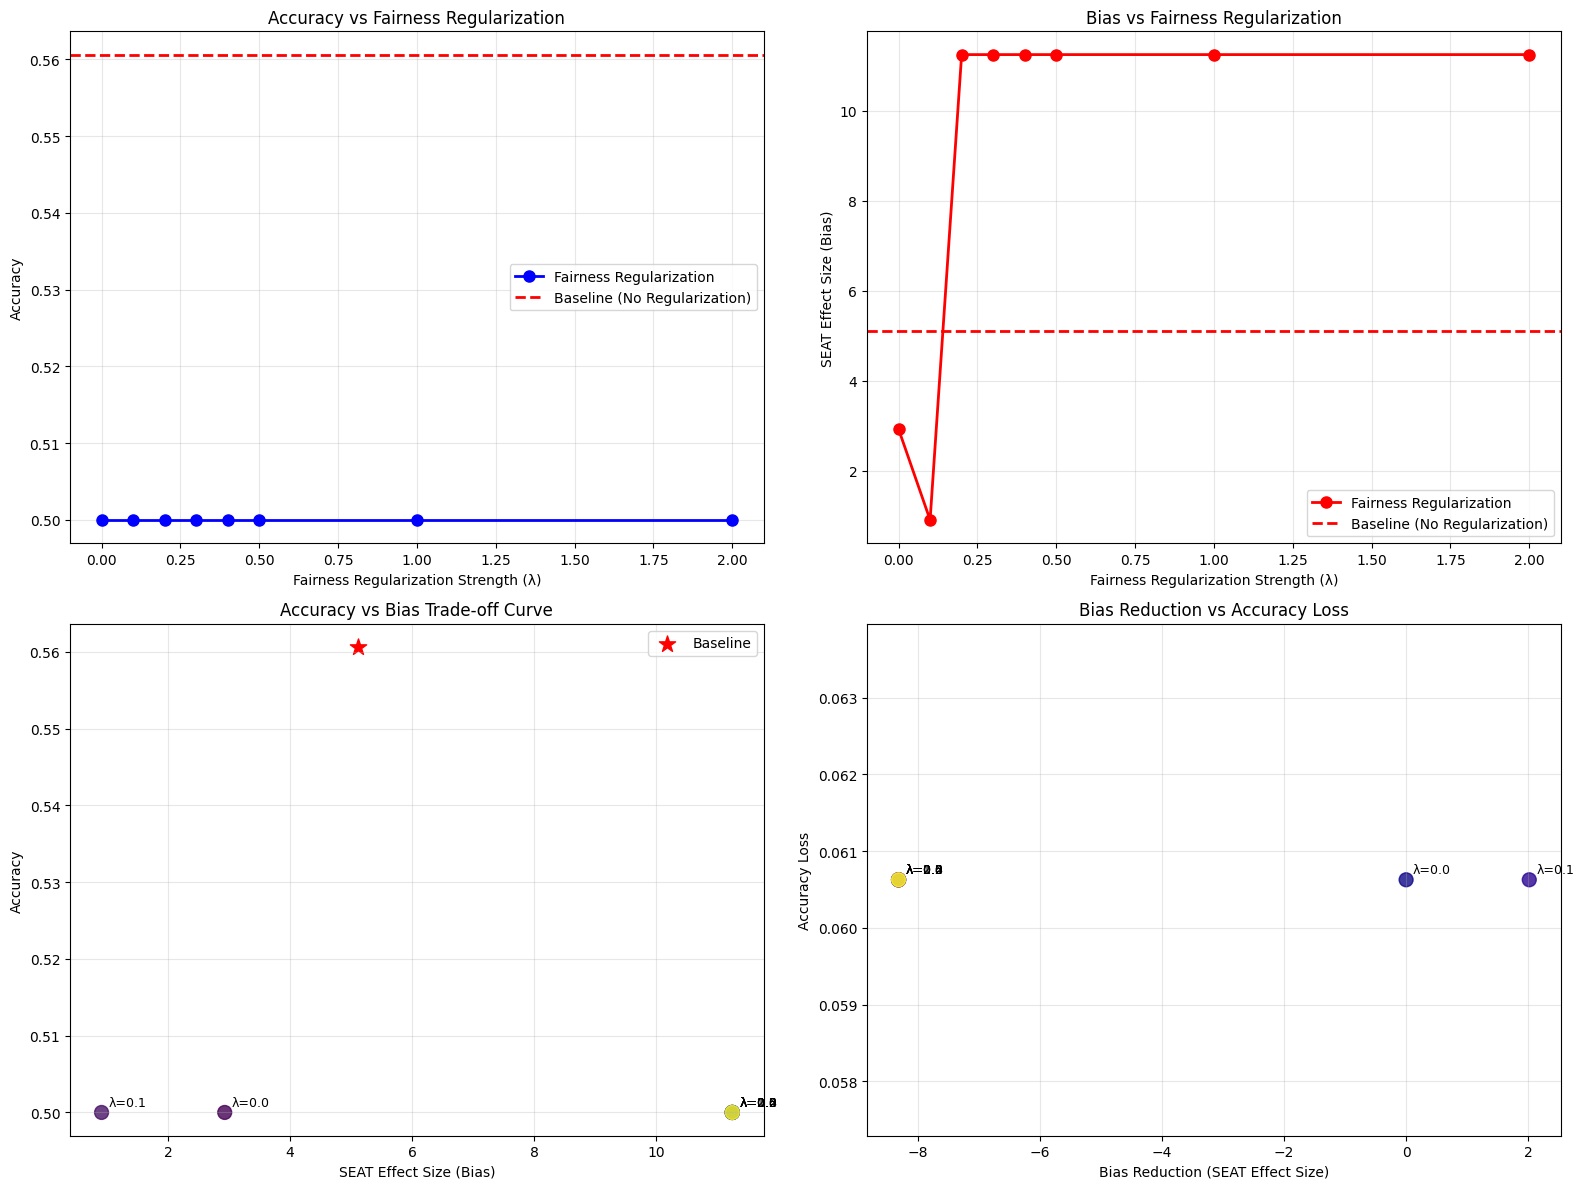

OPTIMAL CONFIGURATIONS:
   Best Bias Reduction: λ=0.1
      Bias Reduction: 2.0180
      Accuracy: 0.5000
      Accuracy Loss: 0.0606
   Best Accuracy: λ=0.0
      Accuracy: 0.5000
      Bias Reduction: 0.0000
   Best Efficiency: λ=0.1
      Efficiency Score: 33.29
      Bias Reduction: 2.0180
      Accuracy Loss: 0.0606
SUMMARY STATISTICS:
   Baseline Bias: 5.1087
   Baseline Accuracy: 0.5606
   Max Bias Reduction: 2.0180
   Min Accuracy Loss: 0.0606
   Bias Reduction Range: -8.3167 to 2.0180
   Accuracy Range: 0.5000 to 0.5000
CORRELATIONS:
   λ vs Bias Reduction: -0.473
   λ vs Accuracy: nan
 RECOMMENDED λ = 0.1 for best bias-accuracy balance
   Recommended λ: 0.1
   Bias Reduction: 2.0180
   Accuracy Loss: 0.0606


C:\Users\a4293604\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\a4293604\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [34]:

def run_complete_fairness_analysis(baseline_dir="./bias_tracking_results", 
                                  output_dir="./fairness_analysis"):
    """
    Run complete fairness regularization analysis
    
    This function:
    1. Loads baseline results from Part A
    2. Tests multiple fairness regularization strengths
    3. Analyzes accuracy vs bias trade-offs
    4. Provides recommendations
    """
    
    print("🚀 STARTING COMPLETE FAIRNESS ANALYSIS")
    print("="*60)
    
    # Load baseline results
    baseline_data = load_baseline_results(baseline_dir)
    if baseline_data is None:
        return None
    
    # Run trade-off analysis
    all_results, trade_off_analysis = run_trade_off_analysis(baseline_data, output_dir)
    
    
    # Quick summary
    if trade_off_analysis and 'best_configs' in trade_off_analysis and trade_off_analysis['best_configs']:
        best_config = trade_off_analysis['best_configs'].get('best_efficiency', {})
        if best_config:
            print(f"   Recommended λ: {best_config.get('lambda', 'N/A')}")
            print(f"   Bias Reduction: {best_config.get('bias_reduction', 0):.4f}")
            print(f"   Accuracy Loss: {best_config.get('accuracy_loss', 0):.4f}")
    
    return {
        'all_results': all_results,
        'trade_off_analysis': trade_off_analysis,
        'baseline_data': baseline_data
    }


results = run_complete_fairness_analysis(
    baseline_dir="./bias_tracking_results",
    output_dir="./fairness_analysis"
)

